In [6]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps

In [5]:
ds_mesh = xr.open_dataset("../../FESOM_data/channel/fesom.mesh.diag.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/gxfs_work/geomar/smomw662/FESOMparcels_first/FESOM_data/channel/fesom.mesh.diag.nc'

In [2]:
ds_mesh = xr.open_dataset("../../FESOM_data/channel/fesom.mesh.diag.nc")
#now we define new coords
ds_mesh = ds_mesh.assign_coords(
    nod2=list(range(1, ds_mesh.sizes["nod2"]+1)), 
    elem=list(range(1,ds_mesh.sizes['elem']+1)),
)

#corners
elem_corner_lons = ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
elem_corner_lats = ds_mesh.lat.sel(nod2=ds_mesh.face_nodes)

max_elem_lon_range = 0.2
tri_overlap=(elem_corner_lons.max('n3') - elem_corner_lons.min('n3')) > max_elem_lon_range

near_channel_width =4
channel_width = 4.5
elem_corner_lons_unglued = xr.where(tri_overlap & (elem_corner_lons > near_channel_width), 
                                   elem_corner_lons - channel_width, elem_corner_lons)


elem_center_lons_unglued = elem_corner_lons_unglued.mean('n3')
elem_center_lats = elem_corner_lats.mean('n3')

elem_center_lons = elem_corner_lons.mean('n3')

## assign coordinates to the mesh
ds_mesh = ds_mesh.assign_coords(
    elem_center_lons=elem_center_lons_unglued,
    elem_center_lats=elem_center_lats,
)
#nearest neighbour interpolation
ds_mesh.xoak.set_index(['elem_center_lats','elem_center_lons'], 'sklearn_geo_balltree')

channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0,18)
number_lon = 2*72 
number_lat = 2*292

# w_lon = number_lon
# w_lat = number_lat
# w_lon = int(2*51.5)
# w_lat = int(2*206)

grid_lon = xr.DataArray(np.linspace(*channel_lon_bds,number_lon), 
                        dims=('grid_lon',))
grid_lat = xr.DataArray(np.linspace(*channel_lat_bds,number_lat),
                        dims=('grid_lat',))

#reorder the lat and lon into a C grid
target_lon, target_lat = xr.broadcast(grid_lon, grid_lat)

#select the grid elements
grid_elems = ds_mesh.xoak.sel(
    elem_center_lats = target_lat,
    elem_center_lons = target_lon,
).elem

grid_elems = grid_elems.assign_coords(
    target_lat = target_lat,
    target_lon = target_lon,
)

grid_elems = grid_elems.assign_coords(
    grid_lat=grid_lat,
    grid_lon=grid_lon,
)

## modify the mesh for nodes and 
ds_mesh = ds_mesh.assign_coords(
    lat=("nod2", ds_mesh.lat.data.flatten()),
    lon=("nod2", ds_mesh.lon.data.flatten()),
)
#
# Ensure the xoak index 
ds_mesh.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")

#-------------get the nod2grids
#grid_nodes
grid_nodes = ds_mesh.xoak.sel(
    lat = target_latw,
    lon = target_lonw,
).nod2

# grid_nodes = grid_nodes.assign_coords(
#     target_lat = target_lat,
#     target_lon = target_lon,
#     grid_lat = grid_lat,
#     grid_lon = grid_lonw,
# )

FileNotFoundError: [Errno 2] No such file or directory: '/gxfs_work/geomar/smomw662/FESOMparcels_first/FESOM_data/channel/fesom.mesh.diag.nc'

In [3]:
print(mesh_diag)


NameError: name 'mesh_diag' is not defined

### U and V

In [3]:
ds_u = xr.open_mfdataset('../../FESOM_data/channel/u.fesom.2005.nc',
                         chunks ={'time':1, 'nz1': 1}).isel(time=slice(0,4))
# first selecting only the surface nz1=0
ds_v = xr.open_mfdataset('../../FESOM_data/channel/v.fesom.2005.nc',
                         chunks = {'time':1, 'nz1':1}).isel(time=slice(0,4))

/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


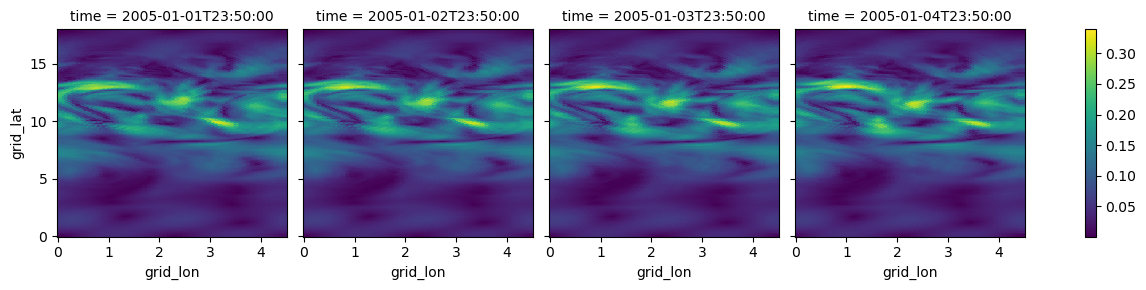

In [4]:
U_grid = ds_u.u.isel(elem=grid_elems - 1).compute() 
V_grid = ds_v.v.isel(elem=grid_elems - 1).compute()

SPD_grid = (U_grid**2 + V_grid**2) **0.5
SPD_grid.isel(time=slice(None,16),nz1=39).plot(x='grid_lon', 
                                        y='grid_lat', col='time',col_wrap=4)

### W 

In [5]:
ds_w = xr.open_mfdataset('../../FESOM_data/channel/w.fesom.2005.nc',
                         chunks = {'time':1, 'nz':1}).isel(time=slice(0,4))
ds_w

/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 7MB
Dimensions:  (nz: 41, time: 4, nod2: 10608)
Coordinates:
  * nz       (nz) float64 328B 0.0 9.038 18.98 ... 3.29e+03 3.628e+03 4e+03
  * time     (time) datetime64[ns] 32B 2005-01-01T23:50:00 ... 2005-01-04T23:...
Dimensions without coordinates: nod2
Data variables:
    w        (time, nz, nod2) float32 7MB dask.array<chunksize=(1, 1, 10608), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                         UGRID-1.0
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       ab6d892b
    FESOM_MeshPath:                      /albedo/work/projects/p_clidyn_work/...
    FESOM_mesh_representative_checksum:  
    ...                                  ...
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      0
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    0
    FESOM_autorotate_back_to_geo:        0

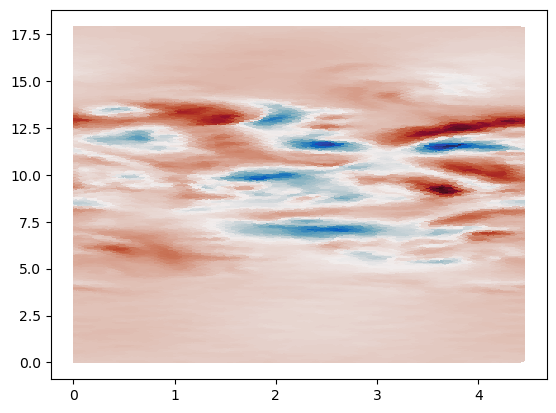

In [8]:
plt.tripcolor(ds_mesh.lon.data,ds_mesh.lat.data,
              ds_w.w.sel(time='2005-01-01',nz=0).values.flatten().transpose(), 
              shading='flat', cmap=cm.balance)

In [12]:
# grid_lonw = xr.DataArray(np.linspace(*channel_lon_bds,w_lon), 
#                         dims=('grid_lon',))
# grid_latw = xr.DataArray(np.linspace(*channel_lat_bds,w_lat),
#                         dims=('grid_lat',))

# #reorder the lat and lon into a C grid
# target_lonw, target_latw = xr.broadcast(grid_lonw, grid_latw)


In [13]:
#select the nodes
# grid_elems = ds_mesh.xoak.sel(
#     elem_center_lats = target_lat,
#     elem_center_lons = target_lon,
# ).elem

# grid_elems = grid_elems.assign_coords(
#     target_lat = target_lat,
#     target_lon = target_lon,
# )

# grid_elems = grid_elems.assign_coords(
#     grid_lat=grid_lat,
#     grid_lon=grid_lon,
# )



# grid_nodes

<xarray.DataArray 'nod2' (grid_lon: 144, grid_lat: 584)> Size: 673kB
array([[    1,     1,     2, ...,   221,   221,   221],
       [    1,     1,     2, ...,   221,   221,   221],
       [  222,   222,     2, ...,   442,   442,   442],
       ...,
       [10388, 10388, 10389, ..., 10608, 10608, 10608],
       [10388, 10389, 10389, ..., 10608, 10608, 10608],
       [10388, 10389, 10389, ..., 10608, 10608, 10608]])
Coordinates:
    lon         (grid_lon, grid_lat) float64 673kB 0.0 0.0 ... 4.406 4.406
    lat         (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0814 ... 17.9 17.9
    nod2        (grid_lon, grid_lat) int64 673kB 1 1 2 2 ... 10608 10608 10608
  * grid_lat    (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.94 17.97 18.0
  * grid_lon    (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.437 4.469 4.5
    target_lat  (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 17.97 18.0
    target_lon  (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5 4.5

In [14]:
W_grid = ds_w.w.isel(nod2=grid_nodes - 1).compute() 
W_grid

<xarray.DataArray 'w' (time: 4, nz: 41, grid_lon: 144, grid_lat: 584)> Size: 55MB
array([[[[-2.53971799e-09, -2.53971799e-09,  2.58052046e-09, ...,
           5.55793500e-09,  5.55793500e-09,  5.55793500e-09],
         [-2.53971799e-09, -2.53971799e-09,  2.58052046e-09, ...,
           5.55793500e-09,  5.55793500e-09,  5.55793500e-09],
         [-4.28638725e-09, -4.28638725e-09,  2.58052046e-09, ...,
           2.83838641e-09,  2.83838641e-09,  2.83838641e-09],
         ...,
         [-5.37354938e-10, -5.37354938e-10,  3.78119092e-09, ...,
           1.03223075e-08,  1.03223075e-08,  1.03223075e-08],
         [-5.37354938e-10,  3.78119092e-09,  3.78119092e-09, ...,
           1.03223075e-08,  1.03223075e-08,  1.03223075e-08],
         [-5.37354938e-10,  3.78119092e-09,  3.78119092e-09, ...,
           1.03223075e-08,  1.03223075e-08,  1.03223075e-08]],

        [[ 2.83567346e-07,  2.83567346e-07,  2.96876905e-08, ...,
           1.48794834e-06,  1.48794834e-06,  1.48794834e-06],
         [ 2.83567346e-07,  2.83567346e-07,  2.96876905e-08, ...,
           1.48794834e-06,  1.48794834e-06,  1.48794834e-06],
         [ 5.03912929e-07,  5.03912929e-07,  2.96876905e-08, ...,
          -9.92855078e-08, -9.92855078e-08, -9.92855078e-08],
...
          -4.25973712e-06, -4.25973712e-06, -4.25973712e-06],
         [ 4.54633391e-06, -5.30442890e-07, -5.30442890e-07, ...,
          -4.25973712e-06, -4.25973712e-06, -4.25973712e-06],
         [ 4.54633391e-06, -5.30442890e-07, -5.30442890e-07, ...,
          -4.25973712e-06, -4.25973712e-06, -4.25973712e-06]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * nz          (nz) float64 328B 0.0 9.038 18.98 ... 3.29e+03 3.628e+03 4e+03
  * time        (time) datetime64[ns] 32B 2005-01-01T23:50:00 ... 2005-01-04T...
    lon         (grid_lon, grid_lat) float64 673kB 0.0 0.0 ... 4.406 4.406
    lat         (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0814 ... 17.9 17.9
    nod2        (grid_lon, grid_lat) int64 673kB 1 1 2 2 ... 10608 10608 10608
  * grid_lat    (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.94 17.97 18.0
  * grid_lon    (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.437 4.469 4.5
    target_lat  (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 17.97 18.0
    target_lon  (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5 4.5
Attributes:
    description:  vertical velocity
    long_name:    vertical velocity
    units:        m/s
    location:     node
    mesh:         fesom_mesh

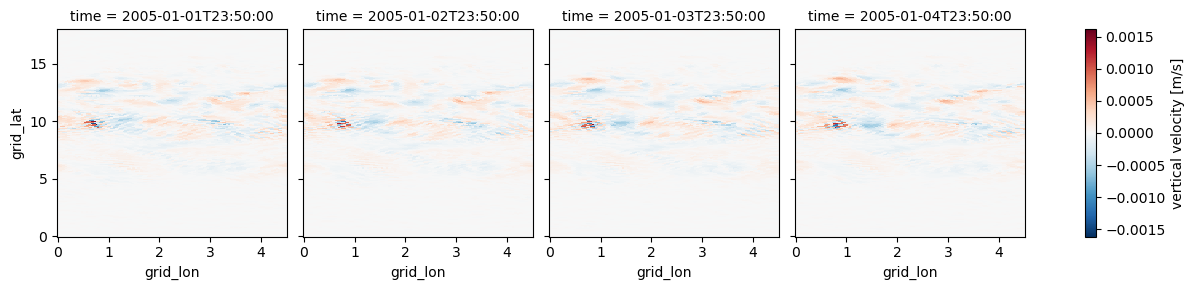

In [15]:
W_grid.isel(time=slice(None,16),nz=23).plot(x='grid_lon', 
                                        y='grid_lat', col='time',col_wrap=4)

In [16]:
print('U:'+str(U_grid.shape))
print('V:'+str(V_grid.shape))
print('W:'+str(W_grid.shape))

U:(4, 40, 144, 584)
V:(4, 40, 144, 584)
W:(4, 41, 144, 584)


In [17]:
print(W_grid.nz.values)
print(V_grid.nz1.values)
print(np.diff(np.diff(V_grid.nz1.values)))

[   0.         9.03766   18.9791    29.9146    41.9438    55.1758
   69.731     85.7418   103.354    122.727    144.037    167.478
  193.264    221.628    252.828    287.149    324.901    366.429
  412.11     462.358    517.632    578.433    645.314    718.883
  799.809    888.827    986.747   1094.46    1212.94    1343.28
 1486.64    1644.34    1817.81    2008.63    2218.53    2449.43
 2703.41    2982.78    3290.1     3628.15    4000.     ]
[   4.51883   14.00838   24.44685   35.9292    48.5598    62.4534
   77.7364    94.5479   113.0405   133.382    155.7575   180.371
  207.446    237.228    269.9885   306.025    345.665    389.2695
  437.234    489.995    548.0325   611.8735   682.0985   759.346
  844.318    937.787   1040.6035  1153.7     1278.11    1414.96
 1565.49    1731.075   1913.22    2113.58    2333.98    2576.42
 2843.095   3136.44    3459.125   3814.075  ]
[ 0.94892  1.04388  1.14825  1.263    1.3894   1.5285   1.6811   1.8489
  2.034    2.238    2.4615   2.707    2.9785  

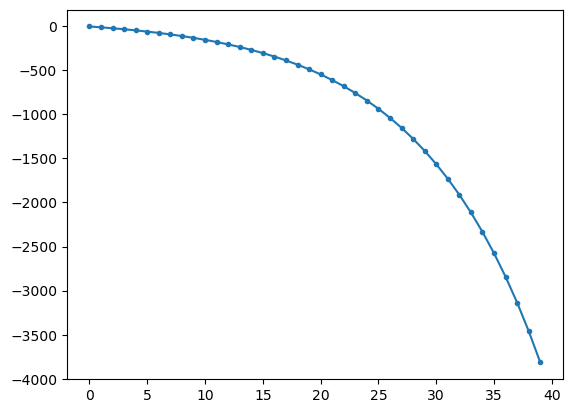

In [18]:
#plt.plot(np.diff(V_grid.nz1.values),marker='.')
plt.plot(-V_grid.nz1.values,marker='.')

In [19]:
channel_z = (0,4000)
z_levels = 1000

## Interpolation of the U,V,W

In [20]:
za = W_grid.nz.values #41
zb = V_grid.nz1.values #40

zc = np.array(sorted(np.concatenate((za, zb))))
#print(zc)

zg = np.sort(np.hstack((0.5 * (zc[0:-1] + zc[1:]), zc)))

#np.set_printoptions(precision=2, suppress=True)
print(zg.shape)

(161,)


In [21]:
target_lat, target_lon, target_z = xr.broadcast(
    xr.DataArray(grid_lat, dims="lat"),
    xr.DataArray(grid_lon, dims="lon"),
    xr.DataArray(zg, dims="z"),
)

In [23]:
# Add the interpolated depth as a new coordinate
ds_mesh = ds_mesh.assign_coords(z=("z", zg))
ds_mesh
# If necessary, update the dataset to remove old dimensions
#ds_mesh = ds_mesh.drop_dims(["nz", "nz1"])


<xarray.Dataset> Size: 9MB
Dimensions:            (nz: 41, nz1: 40, elem: 21120, nod2: 10608, n3: 3,
                        n2: 2, edg_n: 31728, N: 6, n4: 4, z: 161)
Coordinates:
  * nz                 (nz) float64 328B 0.0 9.038 18.98 ... 3.628e+03 4e+03
  * nz1                (nz1) float64 320B 4.519 14.01 ... 3.459e+03 3.814e+03
    lon                (nod2) float64 85kB 0.0 0.0469 0.0 ... 4.406 4.453 4.406
    lat                (nod2) float64 85kB 0.0 0.0814 0.1628 ... 17.82 17.9
  * nod2               (nod2) int64 85kB 1 2 3 4 5 ... 10605 10606 10607 10608
  * elem               (elem) int64 169kB 1 2 3 4 5 ... 21117 21118 21119 21120
    elem_center_lons   (elem) float64 169kB 0.0469 0.09377 ... -2.752e-16
    elem_center_lats   (elem) float64 169kB 0.02713 0.05427 ... 17.88 17.85
  * z                  (z) float64 1kB 0.0 2.259 4.519 ... 3.907e+03 4e+03
Dimensions without coordinates: n3, n2, edg_n, N, n4
Data variables: (12/19)
    fesom_mesh         int32 4B ...
    elem_area          (elem) float64 169kB ...
    nlevels_nod2D      (nod2) int32 42kB ...
    nlevels            (elem) int32 84kB ...
    nod_in_elem2D_num  (nod2) int32 42kB ...
    nod_part           (nod2) int32 42kB ...
    ...                 ...
    face_links         (n3, elem) float64 507kB ...
    edge_face_links    (n2, edg_n) float64 508kB ...
    nod_in_elem2D      (N, nod2) int32 255kB ...
    edge_cross_dxdy    (n4, edg_n) float64 1MB ...
    gradient_sca_x     (n3, elem) float64 507kB ...
    gradient_sca_y     (n3, elem) float64 507kB ...
Attributes:
    Conventions:  UGRID-1.0

In [93]:
nz_grid = ds_mesh.sel(nz = zg, method = 'nearest').nz
nz_grid.astype(int)

<xarray.DataArray 'nz' (nz: 161)> Size: 1kB
array([   0,    0,    9,    9,    9,    9,    9,   18,   18,   18,   18,
         29,   29,   29,   41,   41,   41,   41,   55,   55,   55,   55,
         69,   69,   69,   69,   85,   85,   85,   85,  103,  103,  103,
        103,  122,  122,  122,  122,  144,  144,  144,  144,  144,  167,
        167,  167,  193,  193,  193,  193,  221,  221,  221,  221,  252,
        252,  252,  252,  252,  287,  287,  287,  287,  324,  324,  324,
        324,  366,  366,  366,  412,  412,  412,  412,  462,  462,  462,
        462,  517,  517,  517,  517,  578,  578,  578,  578,  578,  645,
        645,  645,  718,  718,  718,  718,  799,  799,  799,  799,  888,
        888,  888,  888,  986,  986,  986,  986,  986, 1094, 1094, 1094,
       1212, 1212, 1212, 1212, 1343, 1343, 1343, 1343, 1486, 1486, 1486,
       1486, 1644, 1644, 1644, 1644, 1644, 1817, 1817, 1817, 2008, 2008,
       2008, 2008, 2008, 2218, 2218, 2218, 2449, 2449, 2449, 2449, 2703,
       2703, 2703, 2703, 2982, 2982, 2982, 2982, 3290, 3290, 3290, 3290,
       3628, 3628, 3628, 3628, 3628, 4000, 4000])
Coordinates:
  * nz       (nz) float64 1kB 0.0 0.0 9.038 9.038 ... 3.628e+03 4e+03 4e+03
Attributes:
    long_name:      depth of levels
    standard_name:  
    units:          meters
    positive:       down

In [83]:
zg

array([   0.  ,    2.26,    4.52,    6.78,    9.04,   11.52,   14.01,
         16.49,   18.98,   21.71,   24.45,   27.18,   29.91,   32.92,
         35.93,   38.94,   41.94,   45.25,   48.56,   51.87,   55.18,
         58.81,   62.45,   66.09,   69.73,   73.73,   77.74,   81.74,
         85.74,   90.14,   94.55,   98.95,  103.35,  108.2 ,  113.04,
        117.88,  122.73,  128.05,  133.38,  138.71,  144.04,  149.9 ,
        155.76,  161.62,  167.48,  173.92,  180.37,  186.82,  193.26,
        200.36,  207.45,  214.54,  221.63,  229.43,  237.23,  245.03,
        252.83,  261.41,  269.99,  278.57,  287.15,  296.59,  306.02,
        315.46,  324.9 ,  335.28,  345.66,  356.05,  366.43,  377.85,
        389.27,  400.69,  412.11,  424.67,  437.23,  449.8 ,  462.36,
        476.18,  490.  ,  503.81,  517.63,  532.83,  548.03,  563.23,
        578.43,  595.15,  611.87,  628.59,  645.31,  663.71,  682.1 ,
        700.49,  718.88,  739.11,  759.35,  779.58,  799.81,  822.06,
        844.32,  866

In [88]:
#grid_nodes
print(type(grid_nodes))
print(type(nz_grid))
# W_grid.sel(nod2 = grid_nodes -1 ).isel(nz = nz_grid -1)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


In [96]:
grid_nodes.shape

(144, 584)

In [102]:
#W_grid2 = ds_w.w.isel(nod2=grid_nodes - 1).interp(nz=nz_grid,method = 'linear')



In [101]:
W_grid2 = ds_w.w.isel(nod2=grid_nodes - 1).interp(nz=nz_grid,method = 'nearest')
W_grid2

<xarray.DataArray 'w' (time: 4, nz: 161, grid_lon: 144, grid_lat: 584)> Size: 217MB
dask.array<transpose, shape=(4, 161, 144, 584), dtype=float32, chunksize=(1, 161, 18, 584), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 32B 2005-01-01T23:50:00 ... 2005-01-04T...
    lon         (grid_lon, grid_lat) float64 673kB 0.0 0.0 ... 4.406 4.406
    lat         (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0814 ... 17.9 17.9
    nod2        (grid_lon, grid_lat) int64 673kB 1 1 2 2 ... 10608 10608 10608
  * grid_lat    (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.94 17.97 18.0
  * grid_lon    (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.437 4.469 4.5
    target_lat  (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 17.97 18.0
    target_lon  (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5 4.5
  * nz          (nz) float64 1kB 0.0 0.0 9.038 9.038 ... 3.628e+03 4e+03 4e+03
Attributes:
    description:  vertical velocity
    long_name:    vertical velocity
    units:        m/s
    location:     node
    mesh:         fesom_mesh

In [37]:
""" Idea
    lat_grid, lon_grid
1)    node2_grid = ds_mesh.xoak.sel(lon=lon_grid,lat=lat_grid).nod2

2) z_grid
    nz1_grid = ds_mesh.sel(z1 = z_grid, method = 'nearest').nz1

3) ds.W.isel(nod2 = node2_grid -1 ).isel(nz1 = nz1_grid -1). 
"""

    
    

" Idea\n    lat_grid, lon_grid\n1)    node2_grid = ds_mesh.xoak.sel(lon=lon_grid,lat=lat_grid).nod2\n\n2) z_grid\n    nz1_grid = ds_mesh.sel(z1 = z_grid, method = 'nearest').nz1\n\n3) ds.W.isel(nod2 = node2_grid -1 ).isel(nz1 = nz1_grid -1). \n"

In [25]:
# U_dataset = xr.Dataset(
#     data_vars={
#         'U': (('z','lon','lat'), U_grid.values),
#     },
#     coords = {
#     'z': U_grid.nz1,
#     'time': U_grid.time,
#     'lat': U_grid.grid_lat,
#     'lon': U_grid.grid_lon,
# }

# )

# U_dataset



In [26]:
# U_dataset.xoak.set_index({'3d_index':['lon','lat','z']}, 'sklearn_geo_balltree')

In [27]:
# #nearest neighbour interpolation
# ds_mesh = ds_mesh.assign_coords(
#     z1=("nz1", ds_mesh.nz1.data.flatten()),
#     z=("nz", ds_mesh.nz.data.flatten()),
#    )

# ds_mesh
# ds_mesh.xoak.set_index(['z'], 'sklearn_geo_balltree')
# ds_mesh.xoak.set_index(['z1'], 'sklearn_geo_balltree')

In [28]:
# Ensure the xoak index
# lat_broadcasted, lon_broadcasted, nz1_broadcasted = xr.broadcast(U_grid['grid_lat'], 
#                                                                  U_grid['grid_lon'], U_grid['nz1'])

# U_grid = U_grid.assign_coords(
#     # lat=("grid_lat", lat_broadcasted),
#     # lon=("grid_lon", lon_broadcasted),
#     z=("nz1",nz1_broadcasted.values.flatten()),
# )

# U_grid

In [29]:
# #nearest neighbour interpolation
# U_grid.xoak.set_index(['lat','lon','z'], 'sklearn_geo_balltree')

# Ugrid = U_grid.xoak.sel(
#     z = target_z,
#     lat = target_lat,
#     lon = target_lon,
# )
# Ugrid

In [30]:
# lat_dim = 584
# lon_dim = 144
# z_dim = 161


# Ugrid = xr.DataArray(
#     data=np.zeros((lat_dim, lon_dim, z_dim)),
#     dims=('lat', 'lon', 'z'),
#     coords={'lat': grid_lat, 'lon': grid_lon, 'z': zg},
#     name="Ugrid"
# )

# Vgrid = xr.DataArray(
#     data=np.zeros((lat_dim, lon_dim, z_dim)),
#     dims=('lat', 'lon', 'z'),
#     coords={'lat': grid_lat, 'lon': grid_lon, 'z': zg},
#     name="Vgrid"
# )

# Zgrid = xr.DataArray(
#     data=np.zeros((lat_dim, lon_dim, z_dim)),
#     dims=('lat', 'lon', 'z'),
#     coords={'lat': grid_lat, 'lon': grid_lon, 'z': zg},
#     name="Zgrid"
# )

In [31]:
## we create a Z grid with 100 points
# grid_z = xr.DataArray(np.linspace(*channel_z,z_levels), 
#                         dims=('grid_z',))
# grid_z
## broadcast with z,lat,lon


In [32]:
# ds_mesh

In [33]:
# grid_levels_uv = ds_mesh.xoak.sel(
#     nz1 = grid_z,
#     lat = target_lat,
#     lon = target_lon,
# )

#grid_levels_uv
# grid_nodes = grid_nodes.assign_coords(
#     target_lat = target_latw,
#     target_lon = target_lonw,
#     grid_lat = grid_latw,
#     grid_lon = grid_lonw,
# )


In [34]:
## Create a dataset
# ds_uv_grid= xr.Dataset({
#     'U':U_grid,
#     "V":V_grid,
#     'W':W_grid,
# })

## Now Parcels